Lab 3 - Image captioning {Group 5}

In [ ]:
import pandas 
import numpy 
import tensorflow
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from build import *

In [ ]:
image_dir = r"C:\Users\Harish Vasanth\Desktop\Lulea\ADL\Lab3\Flickr8k_Dataset"
text_dir = r"C:\Users\Harish Vasanth\Desktop\Lulea\ADL\Lab3\Flickr8k_text"

- Here we create a dictionary of the format {image_name:Image_discription} and then save it to a pickle file.

In [ ]:
with open("Flickr8k_text/Flickr8k.token.txt", "r") as f:
    raw_caption = f.read()

caption_dict = caption_dictionary(raw_caption)
caption_dict = caption_cleaning(caption_dict)

#Save the caption_dict for future use
with open("captions.pkl", "wb") as f:
    dump(caption_dict, f)

Lets open a random image and see it's discription

In [ ]:
from PIL import Image
import random

random_index = random.randint(0, len(caption_dict) - 1)
random_image_id = list(caption_dict.keys())[random_index]

random_captions = caption_dict[random_image_id]
image_path = os.path.join(image_dir,random_image_id+".jpg")
image = Image.open(image_path)

# Display the image
plt.imshow(image)   
plt.axis('off')  # Hide axis
description = "\n".join(random_captions)  # Join multiple captions into a single string with line breaks
plt.text(0, -20, description, color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

plt.show()



In [ ]:
def feature_extractions(directory):
    """
    Input: directory of images
    Return: A dictionary of features extracted by VGG-16, size 4096.
    """
    
    model = tf.keras.applications.vgg16.VGG16()
    model = keras.models.Model(inputs=model.input, outputs=model.layers[-2].output) #Remove the final layer
    
    features = {}
    for f in tqdm(os.listdir(directory)):
        filename = directory + "/" + f
        identifier = f.split('.')[0]
        
        image = keras.preprocessing.image.load_img(filename, target_size=(224,224))
        arr = keras.preprocessing.image.img_to_array(image, dtype=np.float32)
        arr = arr.reshape((1, arr.shape[0], arr.shape[1], arr.shape[2]))
        arr = keras.applications.vgg16.preprocess_input(arr)
        feature = model.predict(arr, verbose=0)
        features[identifier] = feature
        
        print("feature extraction: {}".format(f))
    return(features)

features = feature_extractions(r"C:\Users\Harish Vasanth\Desktop\Lulea\ADL\Lab3\Flickr8k_Dataset")
with open("features.pkl", "wb") as f:
    dump(features, f)

In [78]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Load image features and descriptions from pickle files
with open(r'C:\Users\Harish Vasanth\Desktop\Lulea\ADL\Lab3\features.pkl', 'rb') as f:
    image_features = pickle.load(f)

with open(r'C:\Users\Harish Vasanth\Desktop\Lulea\ADL\Lab3\captions.pkl', 'rb') as f:
    image_descriptions = pickle.load(f)


In [79]:
with open("Flickr8k_text/Flickr8k.token.txt", "r") as f:
    raw_caption = f.read()


In [80]:
# Clean Captions

for key in image_descriptions:
    caption = image_descriptions[key]
    temp = []
    for i in caption : 
        caption = i.lower()
        caption = caption.replace('[^A-Za-z]','')
        caption = caption.replace('\s+','')
        caption = '<start> ' + " ".join([word for word in caption.split() if len (word)>1]) + ' <end>'
        temp.append(caption)
    image_descriptions[key] = temp
    

In [81]:
image_descriptions

{'1000268201_693b08cb0e': ['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
  '<start> girl going into wooden building <end>',
  '<start> little girl climbing into wooden playhouse <end>',
  '<start> little girl climbing the stairs to her playhouse <end>',
  '<start> little girl in pink dress going into wooden cabin <end>'],
 '1001773457_577c3a7d70': ['<start> black dog and spotted dog are fighting <end>',
  '<start> black dog and tricolored dog playing with each other on the road <end>',
  '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
  '<start> two dogs of different breeds looking at each other on the road <end>',
  '<start> two dogs on pavement moving toward each other <end>'],
 '1002674143_1b742ab4b8': ['<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>',
  '<start> little girl is sitting in front of large painted rainbow <end>',
  '<start> small gir

In [82]:
all_captions = []
for key in image_descriptions:
    for caption in image_descriptions[key]:
        all_captions.append(caption)

In [88]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length
print("Vocab size is  : {} ".format(vocab_size))
print("Max size of captions is  : {} ".format(max_length))

Vocab size is  : 8809 
Max size of captions is  : 34 


In [91]:
# create data generator to get data in batch (avoids session crash)
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0
                
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [100]:
#### Pre process for key errors :

error_keys = []

for key in image_features:
    check = 0
    for key2 in image_descriptions:
        if (key == key2):
            check = 1
    
    if check != 1 :
        print("Key not present in image_description : {}".format(key))
        error_keys.append(key)
        
        

for key in image_descriptions:
    check = 0
    for key2 in image_features:
        if (key == key2):
            check = 1
    
    if check != 1 :
        print("Key not present in image_features : {}".format(key))
        error_keys.append(key)
        

for i in error_keys:
    if i in image_descriptions :
        del image_descriptions[i]
        print("Key {} has been deleted from image_discriptions".format(key))

        
    if i in image_features:
        del image_features[i]
        print("Key {} has been deleted from image_features".format(key))

    

Key not present in image_features : 2258277193_586949ec62
Key 997722733_0cb5439472 has been deleted from image_discriptions


In [101]:
assert (len(image_features) == len(image_descriptions))

In [110]:
image_ids = list(image_descriptions.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [111]:

# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, image_descriptions, image_features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 564s 2s/step - loss: 2.1479


In [112]:
model_dir = r"C:\Users\Harish Vasanth\Desktop\Lulea\ADL\Lab3\models"
model.save(os.path.join(model_dir,"model_alpha.h5"))


c:\Users\Harish Vasanth\Desktop\GroundUP\.conda\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [114]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = image_descriptions[key]
    # predict the caption for image
    y_pred = predict_caption(model, image_features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))



  0%|          | 0/810 [00:00<?, ?it/s]

  1%|          | 5/810 [00:18<48:22,  3.61s/it]  


KeyboardInterrupt: 

---------------------Actual---------------------
<start> black dog and spotted dog are fighting <end>
<start> black dog and tricolored dog playing with each other on the road <end>
<start> black dog and white dog with brown spots are staring at each other in the street <end>
<start> two dogs of different breeds looking at each other on the road <end>
<start> two dogs on pavement moving toward each other <end>
--------------------Predicted--------------------
startseq two dogs play with each other on the grass end of road end end end end end end end of the road end end end end end end end end end end end end


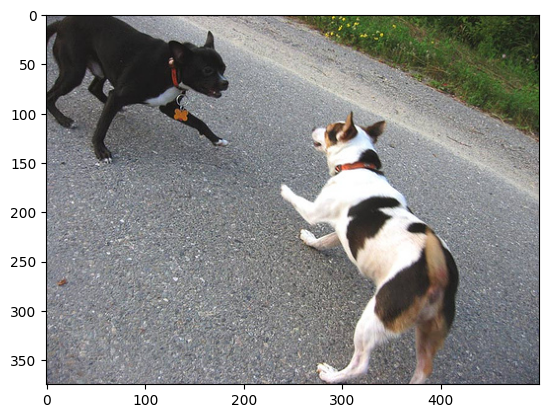

In [118]:

from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(r"C:\Users\Harish Vasanth\Desktop\Lulea\ADL\Lab3\Flickr8k_Dataset", image_name)
    image = Image.open(img_path)
    captions = image_descriptions[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, image_features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)


#### Sample prediction on a random image

---------------------Actual---------------------
<start> black and white dog frolicks in the water <end>
<start> black and white dog leaps through the water <end>
<start> blackandwhite dog running in the water <end>
<start> black and white dog runs through the white water at beach <end>
<start> the black and white dog is running through the ocean <end>
--------------------Predicted--------------------
startseq black black and white dog is running through the water end of red and white dog end end end end end end end end end end end end end end end end end end


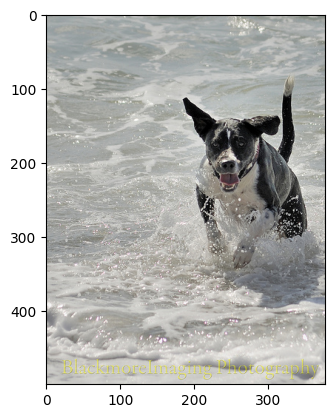

In [127]:
import random 

index = random.randint(0, len(image_descriptions))
random_image_id = list(image_descriptions.keys())[index]
generate_caption(random_image_id+".jpg")